### Loading Necessary Libraries

In [514]:
#from kats.models.prophet import ProphetModel, ProphetParams
#from kats.consts import TimeSeriesData
#from kats.models.var import VARModel, VARParams
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import os
import glob
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

### Read in Data

In [49]:
# read all files from a directory
path = r'/Users/edawg/Desktop/Duke/Time Series/Heart-Rate-Variability-Repo/01_data/1st topic'
rri_files = glob.glob(os.path.join(path, "*_RRI.txt"))
all_patients_df = pd.DataFrame()

for i in range(len(rri_files)):
    patient = rri_files[i].split("/")[-1][0:-8]
    bis_path = path + "/" + patient + "_BIS.txt"
    patient_num = i + 1

    # read in the data
    rri = pd.read_table(rri_files[i], sep=",",names=["time","signal"])
    bis = pd.read_table(bis_path, sep=",",names=["time","signal"])

    # rename signal column
    rri.rename(columns={"signal": "rri_" + str(patient_num)}, inplace=True)
    bis.rename(columns={"signal": "bis_" + str(patient_num)}, inplace=True)

    # merge the data
    patient_df = pd.concat([rri['rri_' + str(patient_num)], bis['bis_' + str(patient_num)]], axis=1)
    all_patients_df = pd.concat([all_patients_df, patient_df], axis=1)

all_patients_df['time'] = all_patients_df.index
all_patients_df['pre_post'] = np.where(all_patients_df['time']<all_patients_df['time'][1440],0,1)
all_patients_df

,rri_1,bis_1,rri_2,bis_2,rri_3,bis_3,rri_4,bis_4,rri_5,bis_5,...,rri_25,bis_25,rri_26,bis_26,rri_27,bis_27,rri_28,bis_28,time,pre_post
0,825.896112,56.164708,859.940135,43.098800,1055.712962,45.324064,656.771280,26.826689,964.467668,32.516983,...,731.866074,32.772420,844.174638,48.706720,1036.769300,37.528583,1104.571104,30.087002,0,0
1,825.899059,56.254664,858.098369,43.013895,1053.145867,45.194152,658.444182,26.801709,966.577226,32.432015,...,731.782331,32.817382,842.900578,48.786638,1040.097782,37.493595,1093.828273,30.111988,1,0
2,826.375276,56.344620,856.832234,42.928991,1049.441234,45.064240,660.013387,26.683644,967.880418,32.347048,...,730.477343,32.862344,844.835599,48.866557,1042.938552,37.458607,1084.926249,30.136973,2,0
3,827.648728,56.428813,856.646906,42.844087,1045.467821,44.934327,661.246011,26.558743,968.716328,32.262080,...,728.749676,32.907305,848.612716,48.946475,1043.992788,37.423619,1080.409352,30.161959,3,0
4,829.692027,56.503777,858.001085,42.759182,1042.094387,44.933087,661.966394,26.433842,969.476936,32.177112,...,727.435389,32.952267,852.054107,49.026393,1042.490969,37.388631,1081.227743,30.186945,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3836,739.525796,46.015123,953.255002,40.131617,852.841400,35.353787,636.117628,2.100000,762.074342,28.416510,...,871.426323,40.124091,1168.519256,57.236577,765.351208,29.514652,878.304499,33.118502,3836,1
3837,738.431676,46.025118,958.937697,40.011752,853.109321,35.378770,636.779477,2.100000,762.639833,28.411512,...,875.308250,40.049155,1167.405411,57.466343,764.515831,29.479664,883.227917,33.008565,3837,1
3838,737.117124,46.035113,961.489002,39.891887,853.377243,35.403753,637.647817,2.100000,763.976446,28.406514,...,878.991623,39.974219,1166.291567,57.562392,757.284474,29.444676,886.297960,32.898627,3838,1
3839,735.944230,46.045108,962.656826,39.772022,853.645164,35.428737,638.777592,2.100000,766.311931,28.401516,...,879.795025,39.899283,1165.177722,57.472484,748.945789,29.409688,887.585408,32.788690,3839,1


### Data Exploration

In [72]:
rris = all_patients_df[[col for col in all_patients_df if col.startswith('rri')]].copy()
rris['time'] = all_patients_df['time']
bis_all = all_patients_df[[col for col in all_patients_df if col.startswith('bis')]].copy()
bis_all['time'] = all_patients_df['time']

Plotting RRI data for all 28 patients

In [78]:
rris['rri_9'].isnull().sum()

0

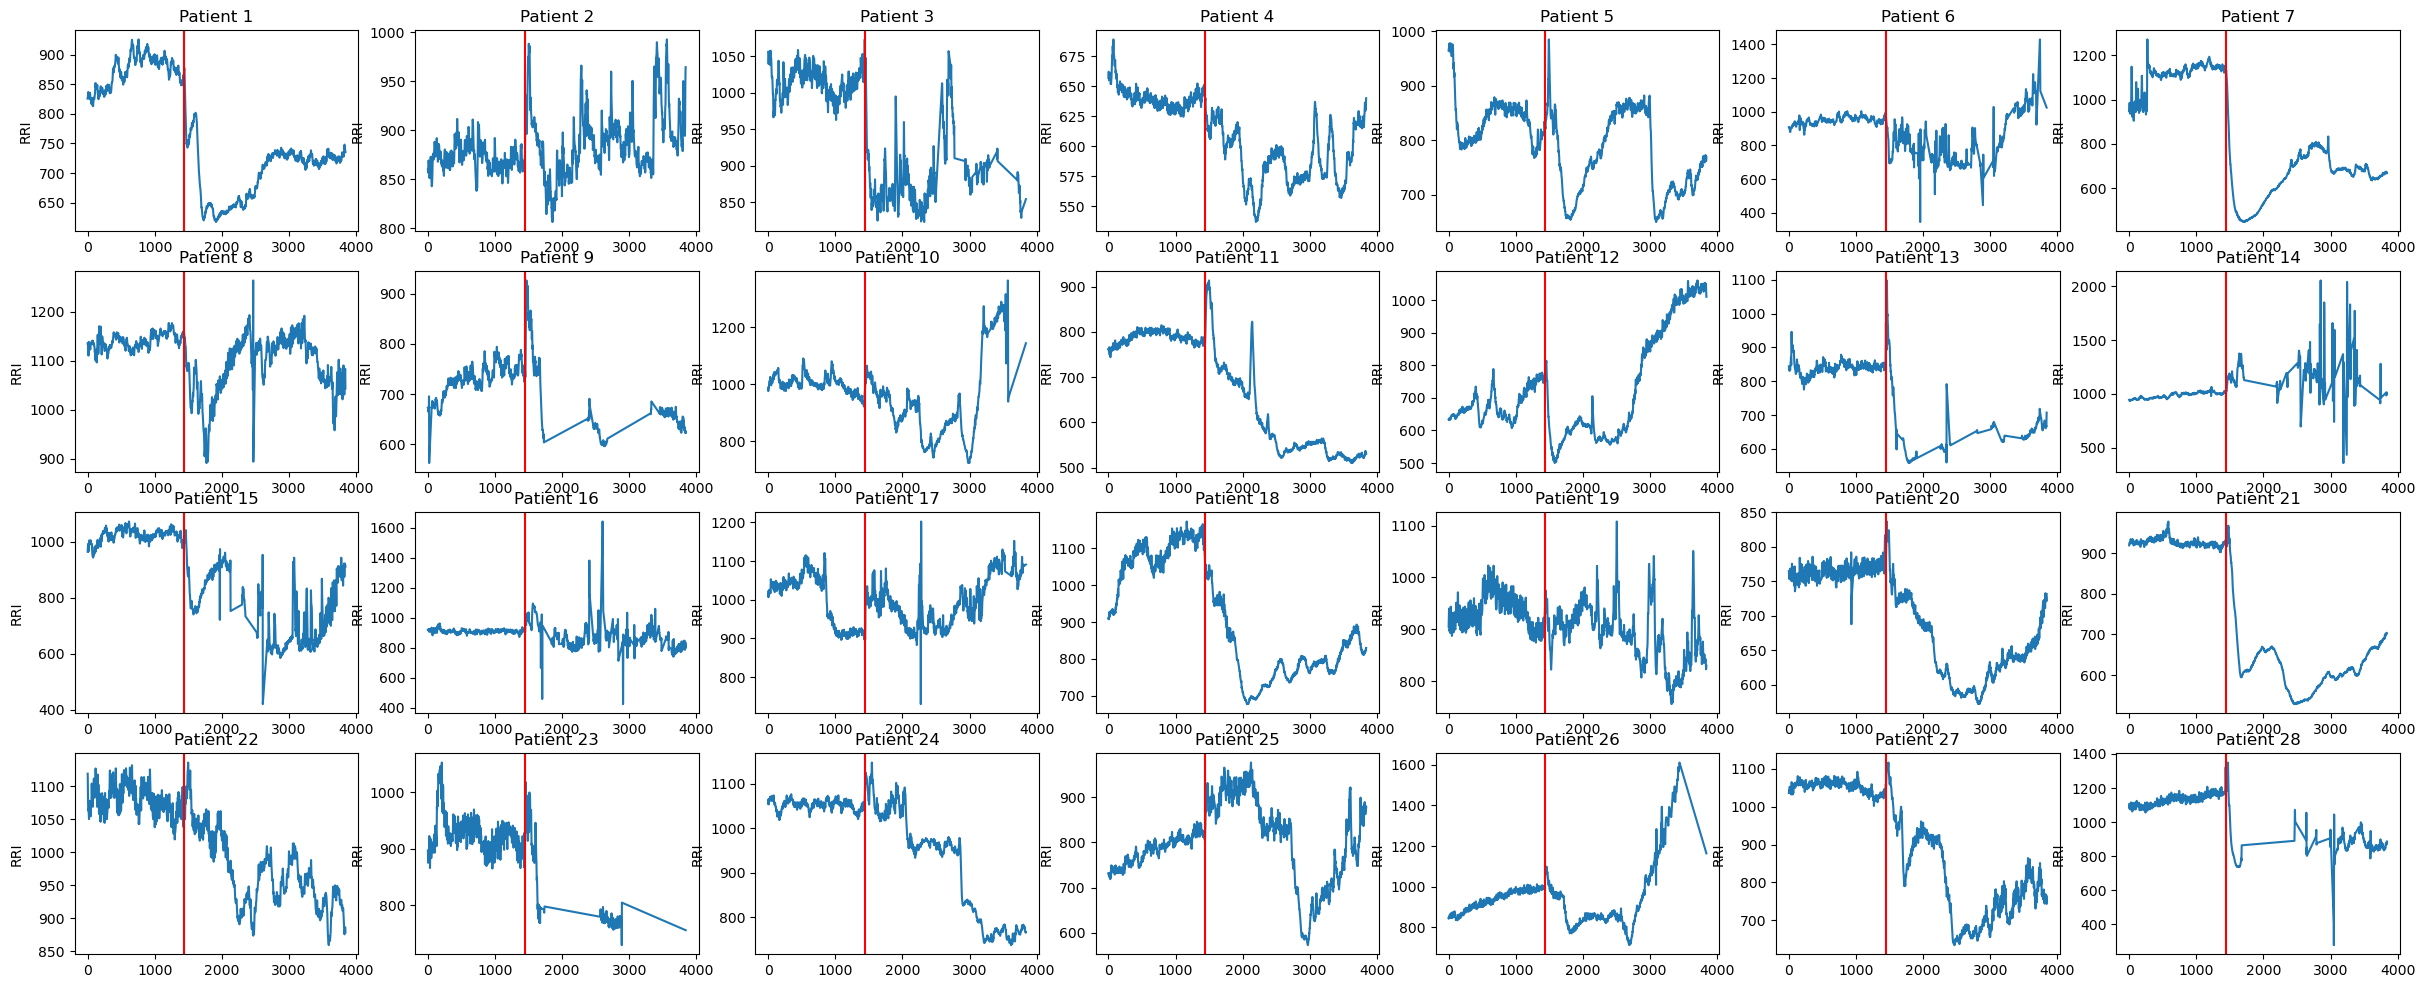

In [73]:
fig, axs = plt.subplots(4, 7, figsize=(30, 12))

for i in range(4):
    for j in range(7):
        axs[i,j].plot(rris['time'], rris["rri_" + str(i*7+j+1)])
        axs[i,j].set_title('Patient ' + str(i*7+j+1))
        axs[i,j].set_ylabel('RRI')
        axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')

Plotting BIS data for all 28 patients:

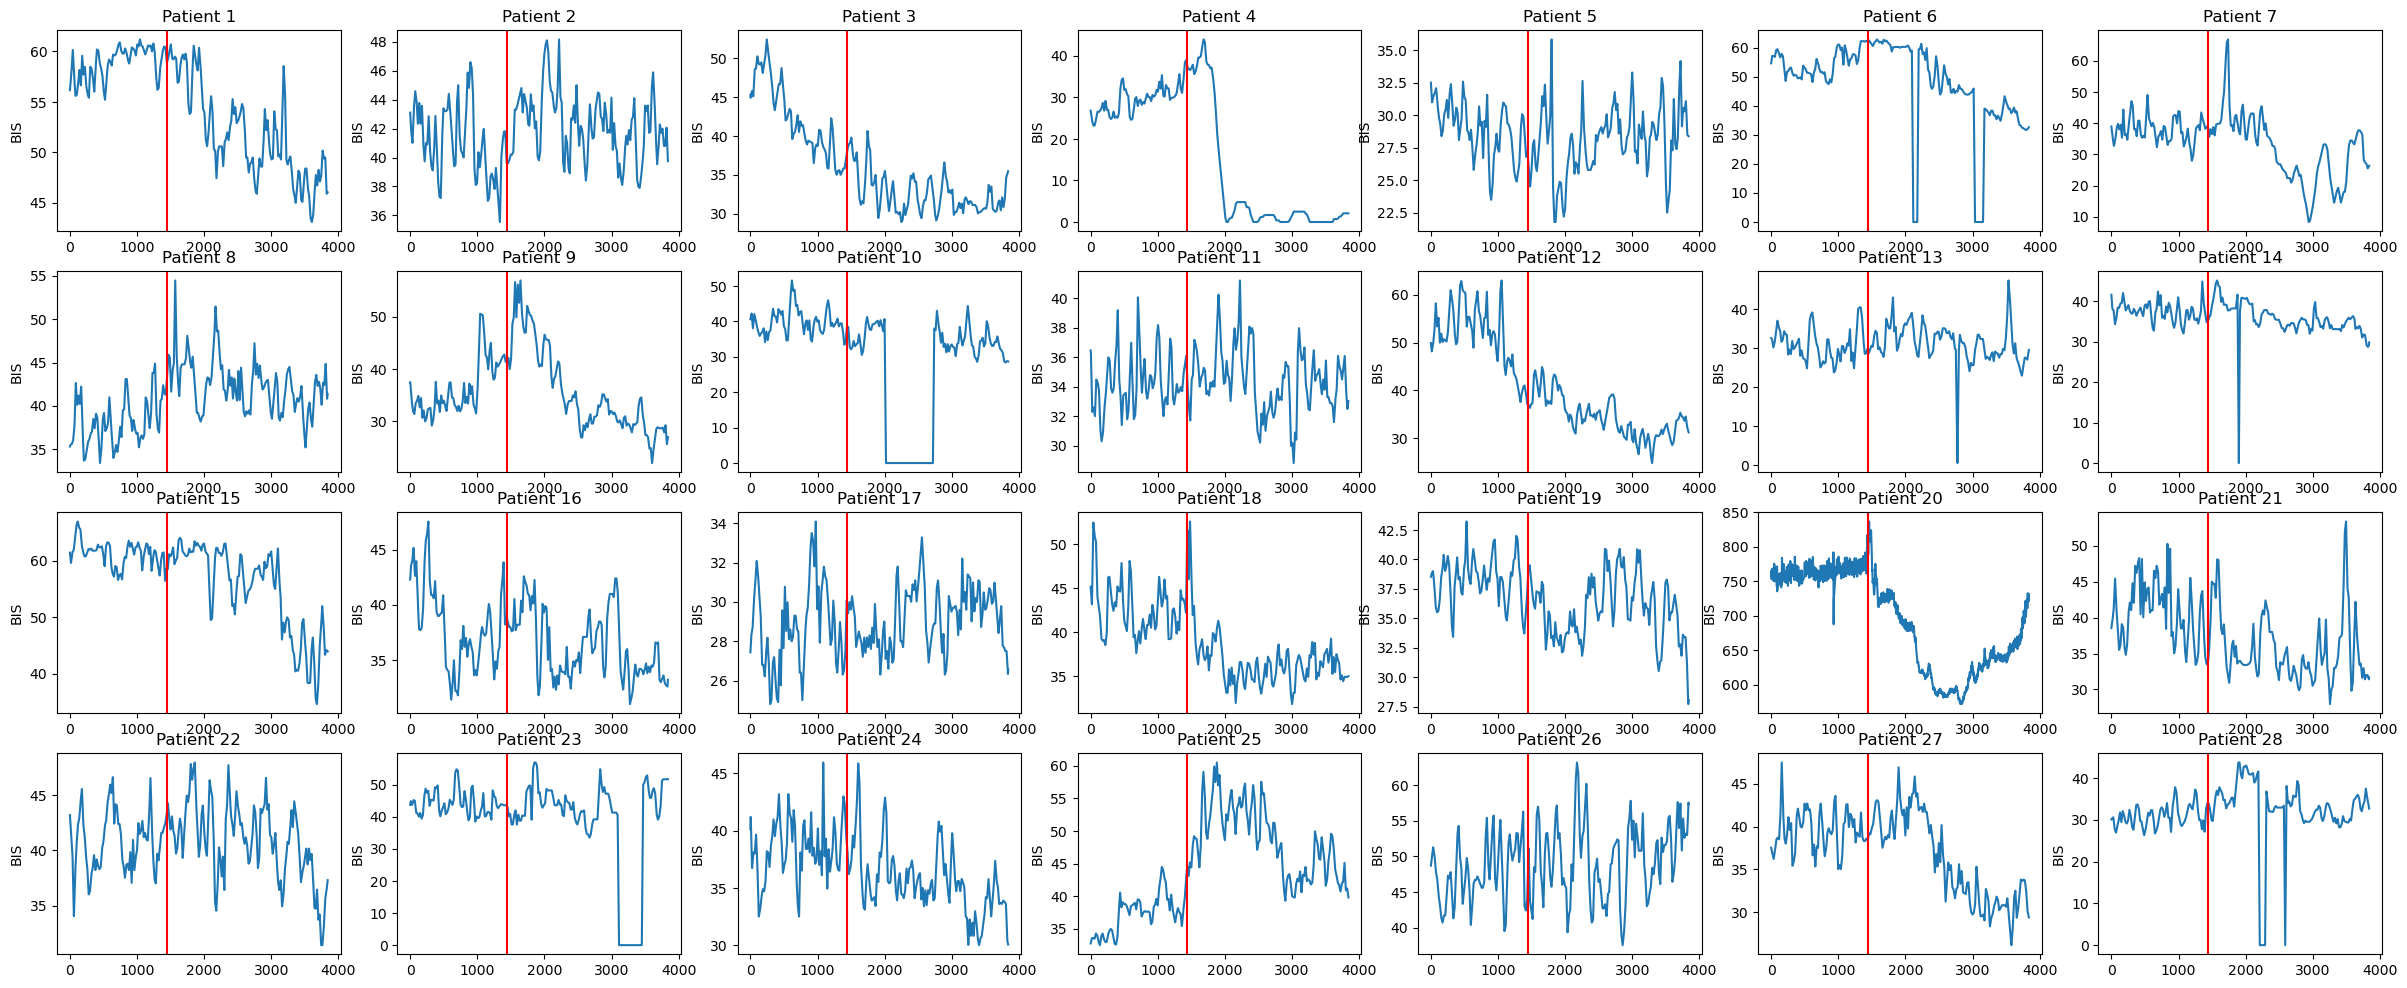

In [75]:
fig, axs = plt.subplots(4, 7, figsize=(30, 12))

for i in range(4):
    for j in range(7):
        axs[i,j].plot(bis_all['time'], bis_all["bis_" + str(i*7+j+1)])
        axs[i,j].set_title('Patient ' + str(i*7+j+1))
        axs[i,j].set_ylabel('BIS')
        axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')

In [70]:
#calculate ADFs for each
# calculate mean times

### Data Preprocessing

1) If we don't have any 0s in the RRI data how do we identify missing data?

- Differencing
- Smoothing
- SST?? What does this do??
- What to do with huge jumps?
- imputing [x] done

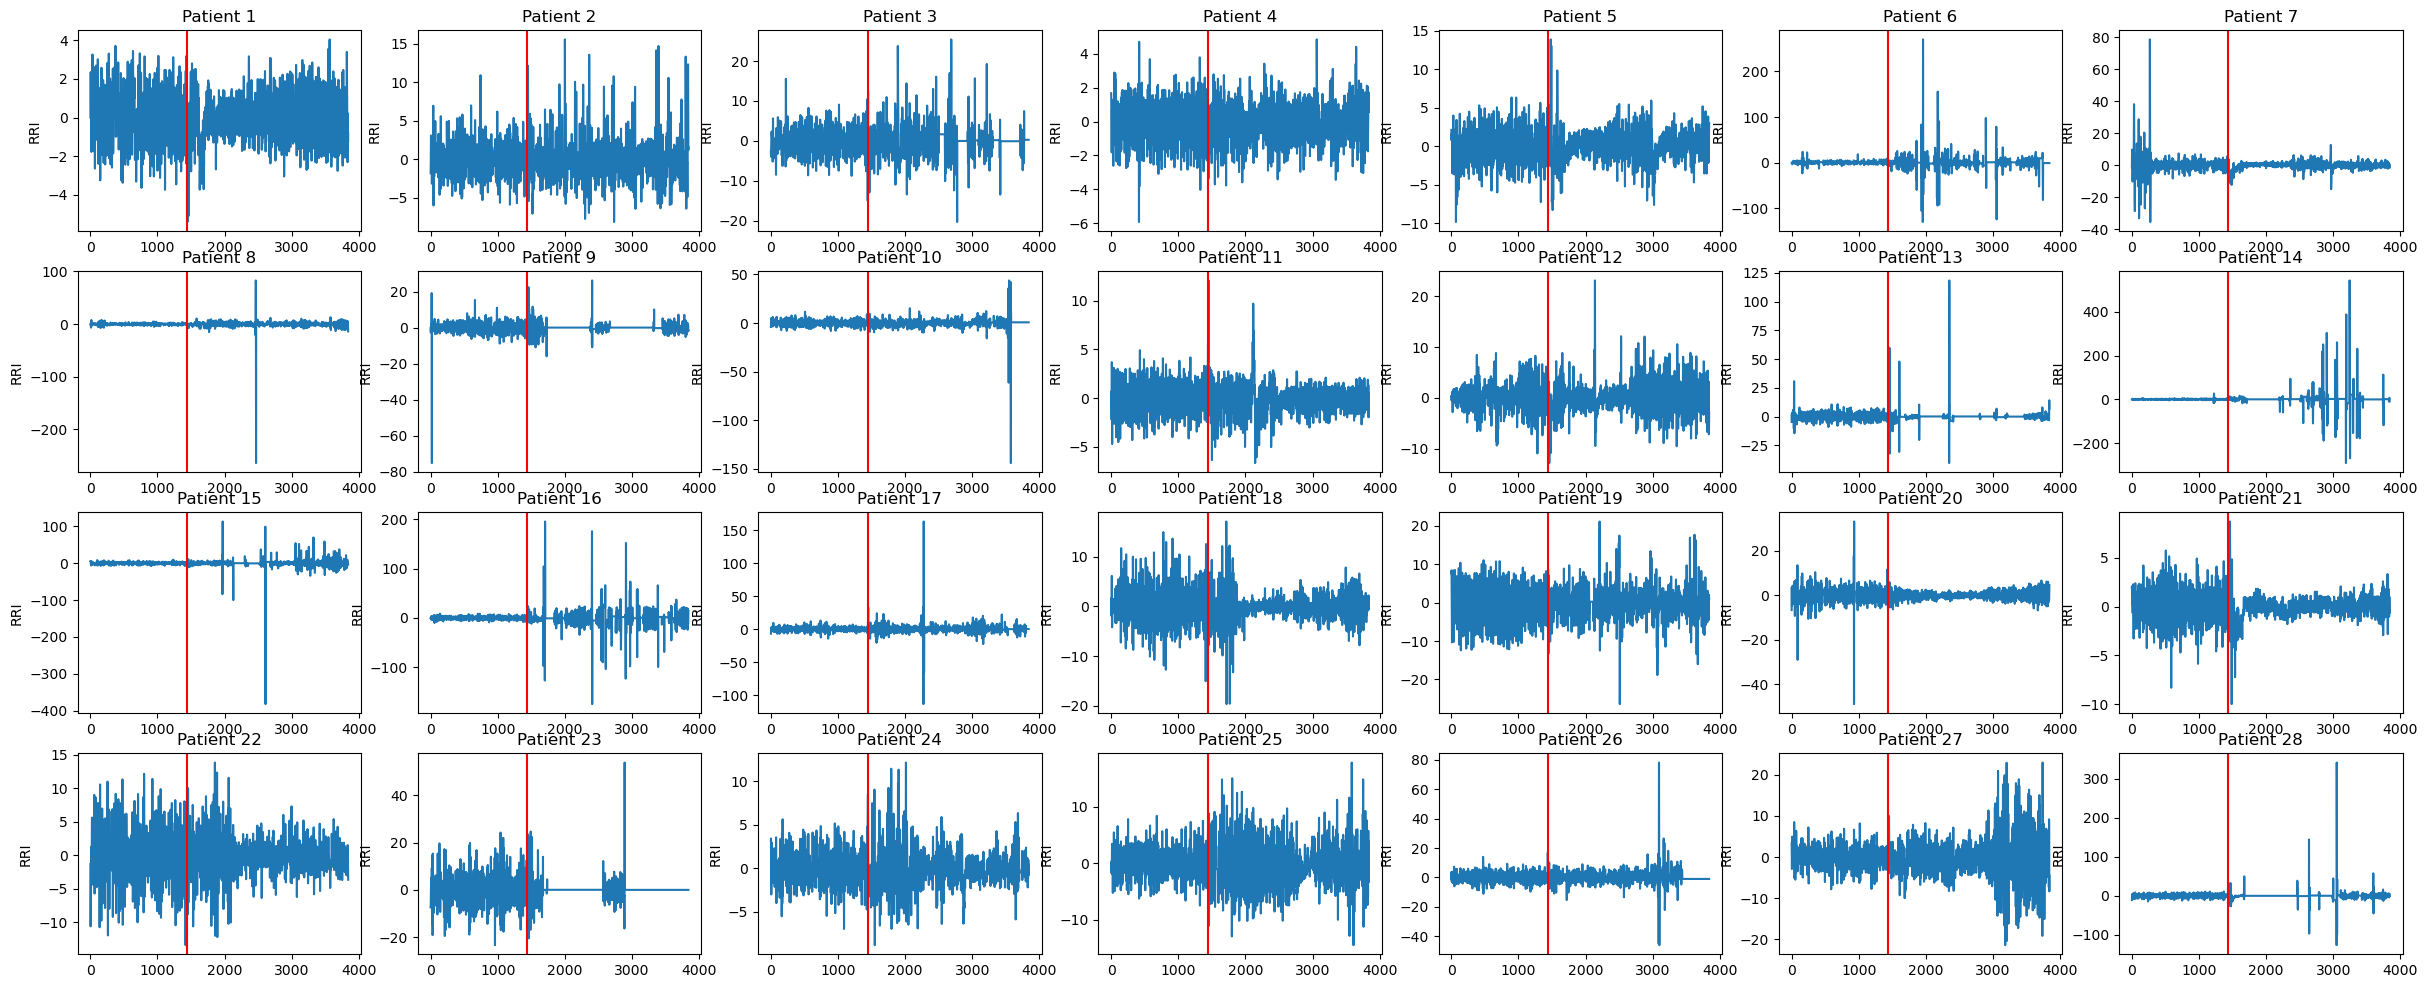

In [119]:
# plot the differences

fig, axs = plt.subplots(4, 7, figsize=(30, 12))

for i in range(4):
    for j in range(7):
        axs[i,j].plot(rris['time'], rris["rri_" + str(i*7+j+1)].diff(periods = 1))
        axs[i,j].set_title('Patient ' + str(i*7+j+1))
        axs[i,j].set_ylabel('RRI')
        axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')


In [134]:
# performing stationarity checks after differencing
patients = []
p_values = []
periods = 1
for patient in range(len(rris.columns) - 1):
    patients.append(patient + 1)
    p_values.append(adfuller(rris.iloc[:,patient].diff(periods = periods).dropna())[1])
stationarity_checks = pd.DataFrame({'patient': patients, 'p-value': p_values})
stationarity_checks['is_stationary'] = np.where(stationarity_checks['p-value'] < 0.05, 1, 0)
print(stationarity_checks['is_stationary'].sum(), ' out of', len(stationarity_checks), ' patients are stationary', "(" + str(round(stationarity_checks['is_stationary'].sum()/len(stationarity_checks)*100, 2)) + "%)")

28  out of 28  patients are stationary (100.0%)


In [499]:
# create a dataset with differenced rris
def differenced_rris(rris, periods):
    rris_diff = pd.DataFrame()
    for patient in range(len(rris.columns) - 1):
        rris_diff['rri_' + str(patient + 1)] = rris.iloc[:,patient].diff(periods = periods).dropna()
    return rris_diff

rris_diff = differenced_rris(rris, periods = 1)

In [147]:
rris_diff.to_csv("rris_diff.csv", index = False)

In [148]:
rris.drop("time", axis = 1, inplace = False).to_csv("rris.csv", index = False)

Exponential smoothing

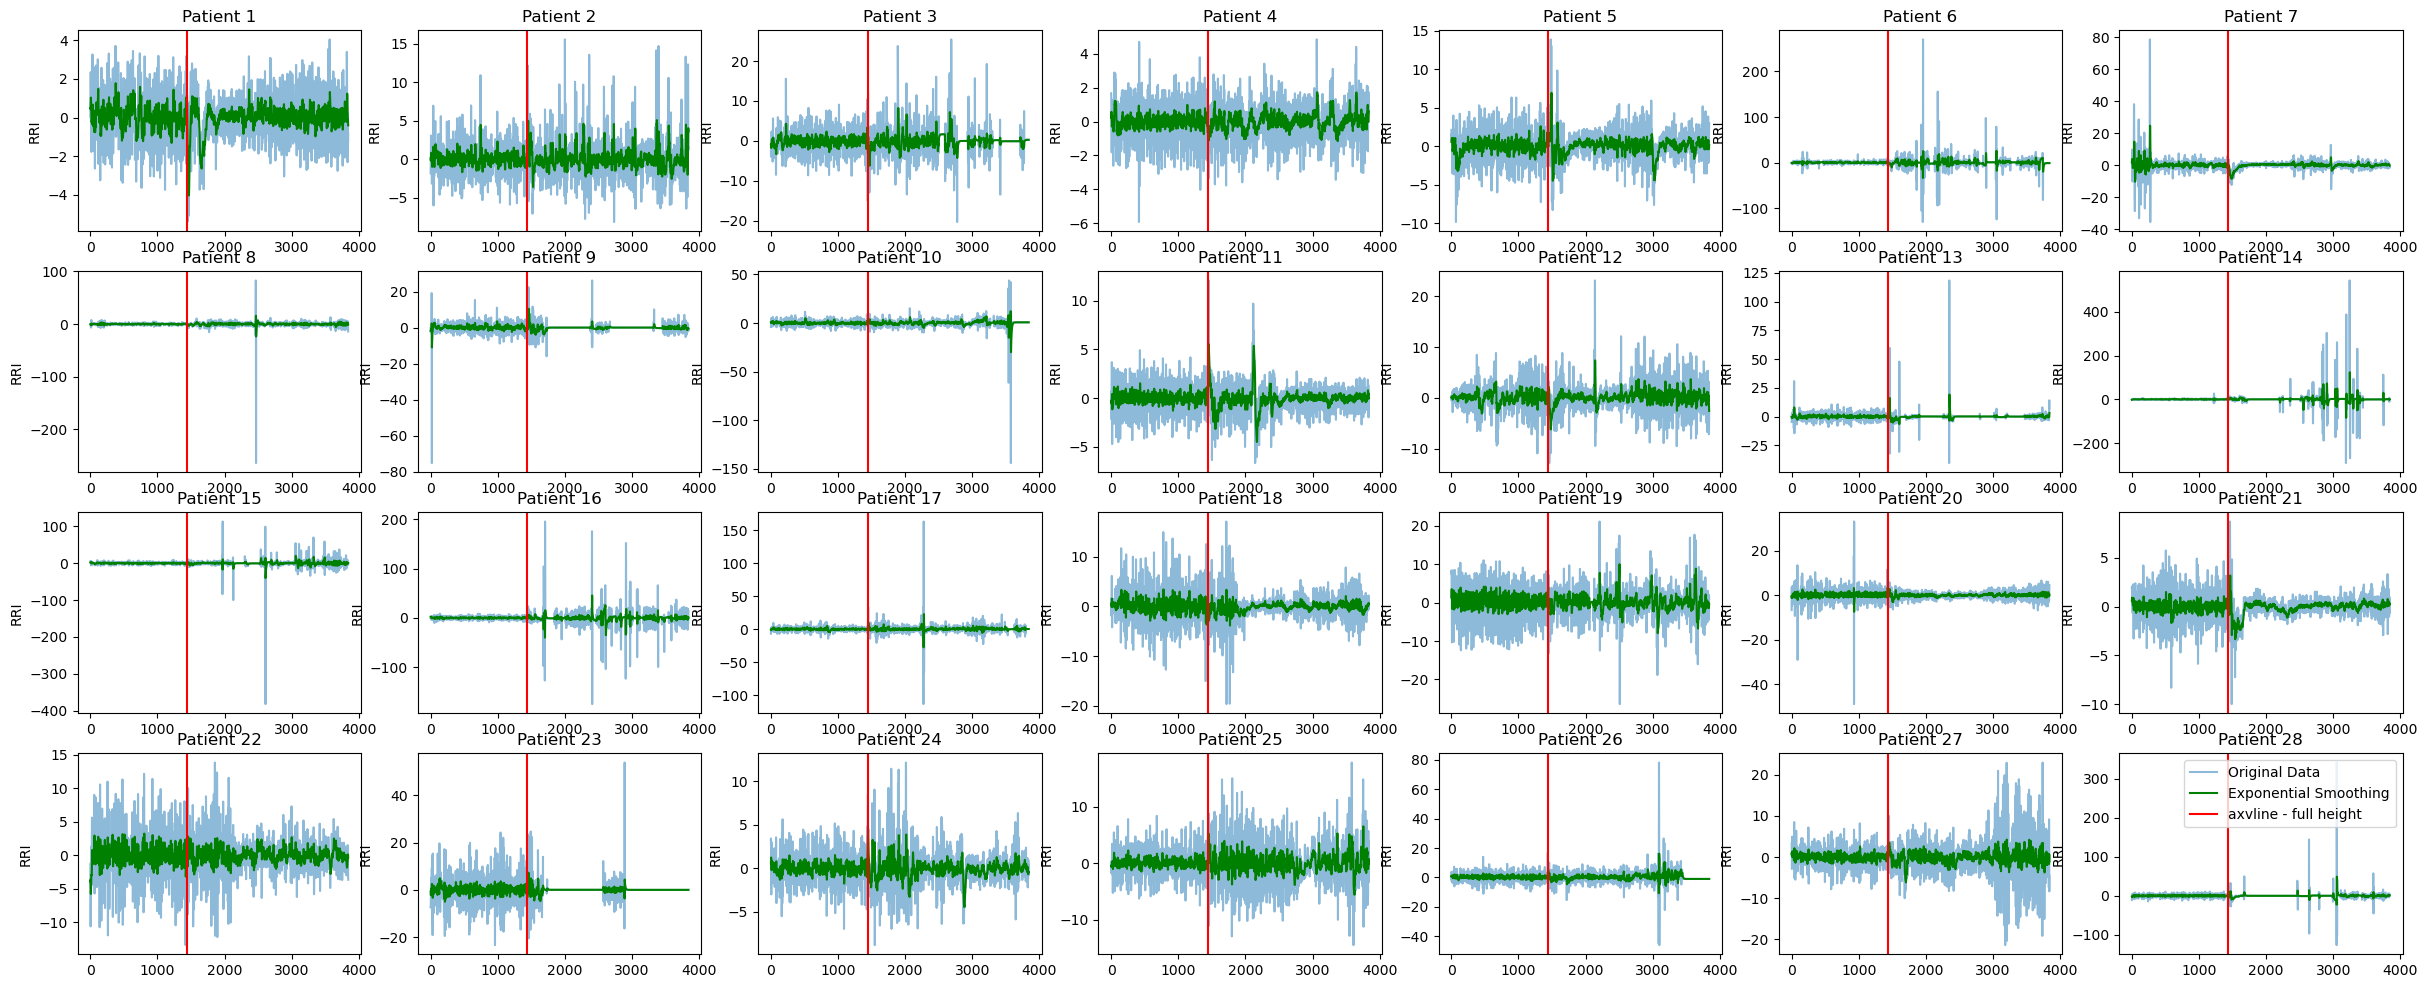

In [326]:
# plots for smoothed data
fig, axs = plt.subplots(4, 7, figsize=(30, 12))
warnings.filterwarnings("ignore")

for i in range(4):
    for j in range(7):
        exp_model = ExponentialSmoothing(rris_diff["rri_" + str(i*7+j+1)], trend = 'add', seasonal = None).fit(smoothing_level = 0.1)
        axs[i,j].plot(rris['time'][1:], rris_diff["rri_" + str(i*7+j+1)], alpha = 0.5, label = 'Original Data')
        axs[i,j].plot(rris['time'][1:], exp_model.fittedvalues, color = 'g', label = 'Exponential Smoothing')
        axs[i,j].set_title('Patient ' + str(i*7+j+1))
        axs[i,j].set_ylabel('RRI')
        axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')
plt.legend()
plt.show()

### GARCH Model Fitting

In [414]:
# Fitting GARCH on exp smoothed and differenced data
test_size = 100
diff = True
patient_num = 24
if diff:
    exp_model = ExponentialSmoothing(
        rris_diff["rri_" + str(patient_num)], trend="add", seasonal=None
    ).fit(smoothing_level=0.1)
    train, test = (
        exp_model.fittedvalues[: len(rris_diff["rri_" + str(patient_num)]) - test_size],
        exp_model.fittedvalues[len(rris_diff["rri_" + str(patient_num)]) - test_size :],
    )
else:
    exp_model = ExponentialSmoothing(
        rris["rri_" + str(patient_num)], trend="add", seasonal=None
    ).fit(smoothing_level=0.1)
    train, test = (
        exp_model.fittedvalues[
            : len(rris["rri_" + str(patient_num)]) - test_size
        ],
        exp_model.fittedvalues[
            len(rris["rri_" + str(patient_num)]) - test_size :
        ],
    )

# fit model
model = arch_model(train, mean="Zero", vol="GARCH", p = 1, q = 1).fit(disp="off")
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2280.03
Distribution:                  Normal   AIC:                           4566.06
Method:            Maximum Likelihood   BIC:                           4584.74
                                        No. Observations:                 3740
Date:                Thu, Apr 13 2023   Df Residuals:                     3740
Time:                        00:20:40   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0175  2.380e-03      7.333  2.242e-13 [1.279e-02,2.211e-02]
alpha[1]       0.8994  1.669e-02     53.885      0.000     [  0.867,  0.932]
beta[1]        0.1006  2.240e-02      4.492  7.060e-06   [5.672e-02,  0.145]
============================================================================

Covariance estimator: robust
"""

1) Preprocessing script
2) Preprocessing slide (Elisa)

Steps:
1) Extract the realized volatility -> (but my understanding is that I can just apply this to the differenced graphs!!)
2) Fit 28 local arch_models and extract the params and store them in three separate arrays --> GARCH (1, 1). You can tune this later maybe. Either use PACF graphs to justify 1,1 or do hyperparameter search.
    - include BIS as the exogenous variable
    - also store the RMSEs of each model
3) calculate the means of each and RMSE. Compare this to the RMSE of ??
4) Apply rolling window or predictions method on test data (6 patients?)

Create a global model by using the means as the starting_value

## 
I know you said that you can fit multiple realizations and take the mean. But are we assuming that we're always fitting the same model GARCH(p, q). What if the optimal p and q differ for each realization. Then what?

240 is test size

In [665]:
def create_datasets(patient, test_size = 240, global_df = None, differencing = True, periods = 1, smoothing = True, smoothing_level = 0.1):
    if global_df is not None:
        patient = pd.concat([global_df, patient], axis = 0)

    if differencing:
        patient = patient.diff(periods = periods).dropna()
        
    if smoothing:
        exp_model = ExponentialSmoothing(patient, trend="add", seasonal=None).fit(smoothing_level=smoothing_level)
        train, test = (
        exp_model.fittedvalues[: len(patient) - test_size],
        exp_model.fittedvalues[len(patient) - test_size :],
    )
    else:
        train, test = (
        patient[: len(patient) - test_size],
        patient[len(patient) - test_size :],
    )
    return train, test

def fit_data(train, test, exog, p = 1, q = 1, make_rolling_predictions = True, window = 5, starting_values = None):
    if make_rolling_predictions:
        # Rolling Forecast
        predictions = []
        curr_train = train.copy()
        for i in range(0, len(test), window):
            model = arch_model(y = curr_train, x = exog, mean="Zero", vol="GARCH", p = p, q = q, rescale = True).fit(disp="off", starting_values = starting_values, update_freq = 0)
            pred = model.forecast(horizon = window, reindex = False)
            predictions.append((np.sqrt(pred.variance.values[-1,:])))
            curr_train = curr_train.append(test[i:i+window])
        predictions = np.reshape(predictions, (1, -1))[0]
    else:
        model = arch_model(y = train, x = exog, mean="Zero", vol="GARCH", p = p, q = q, rescale = True).fit(disp="off")
        predictions = model.forecast(horizon = len(test), reindex = False)
        predictions = np.sqrt(predictions.variance.values[-1,:])
    mse = mean_squared_error(test, predictions)
    return model, mse, predictions

/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
Se

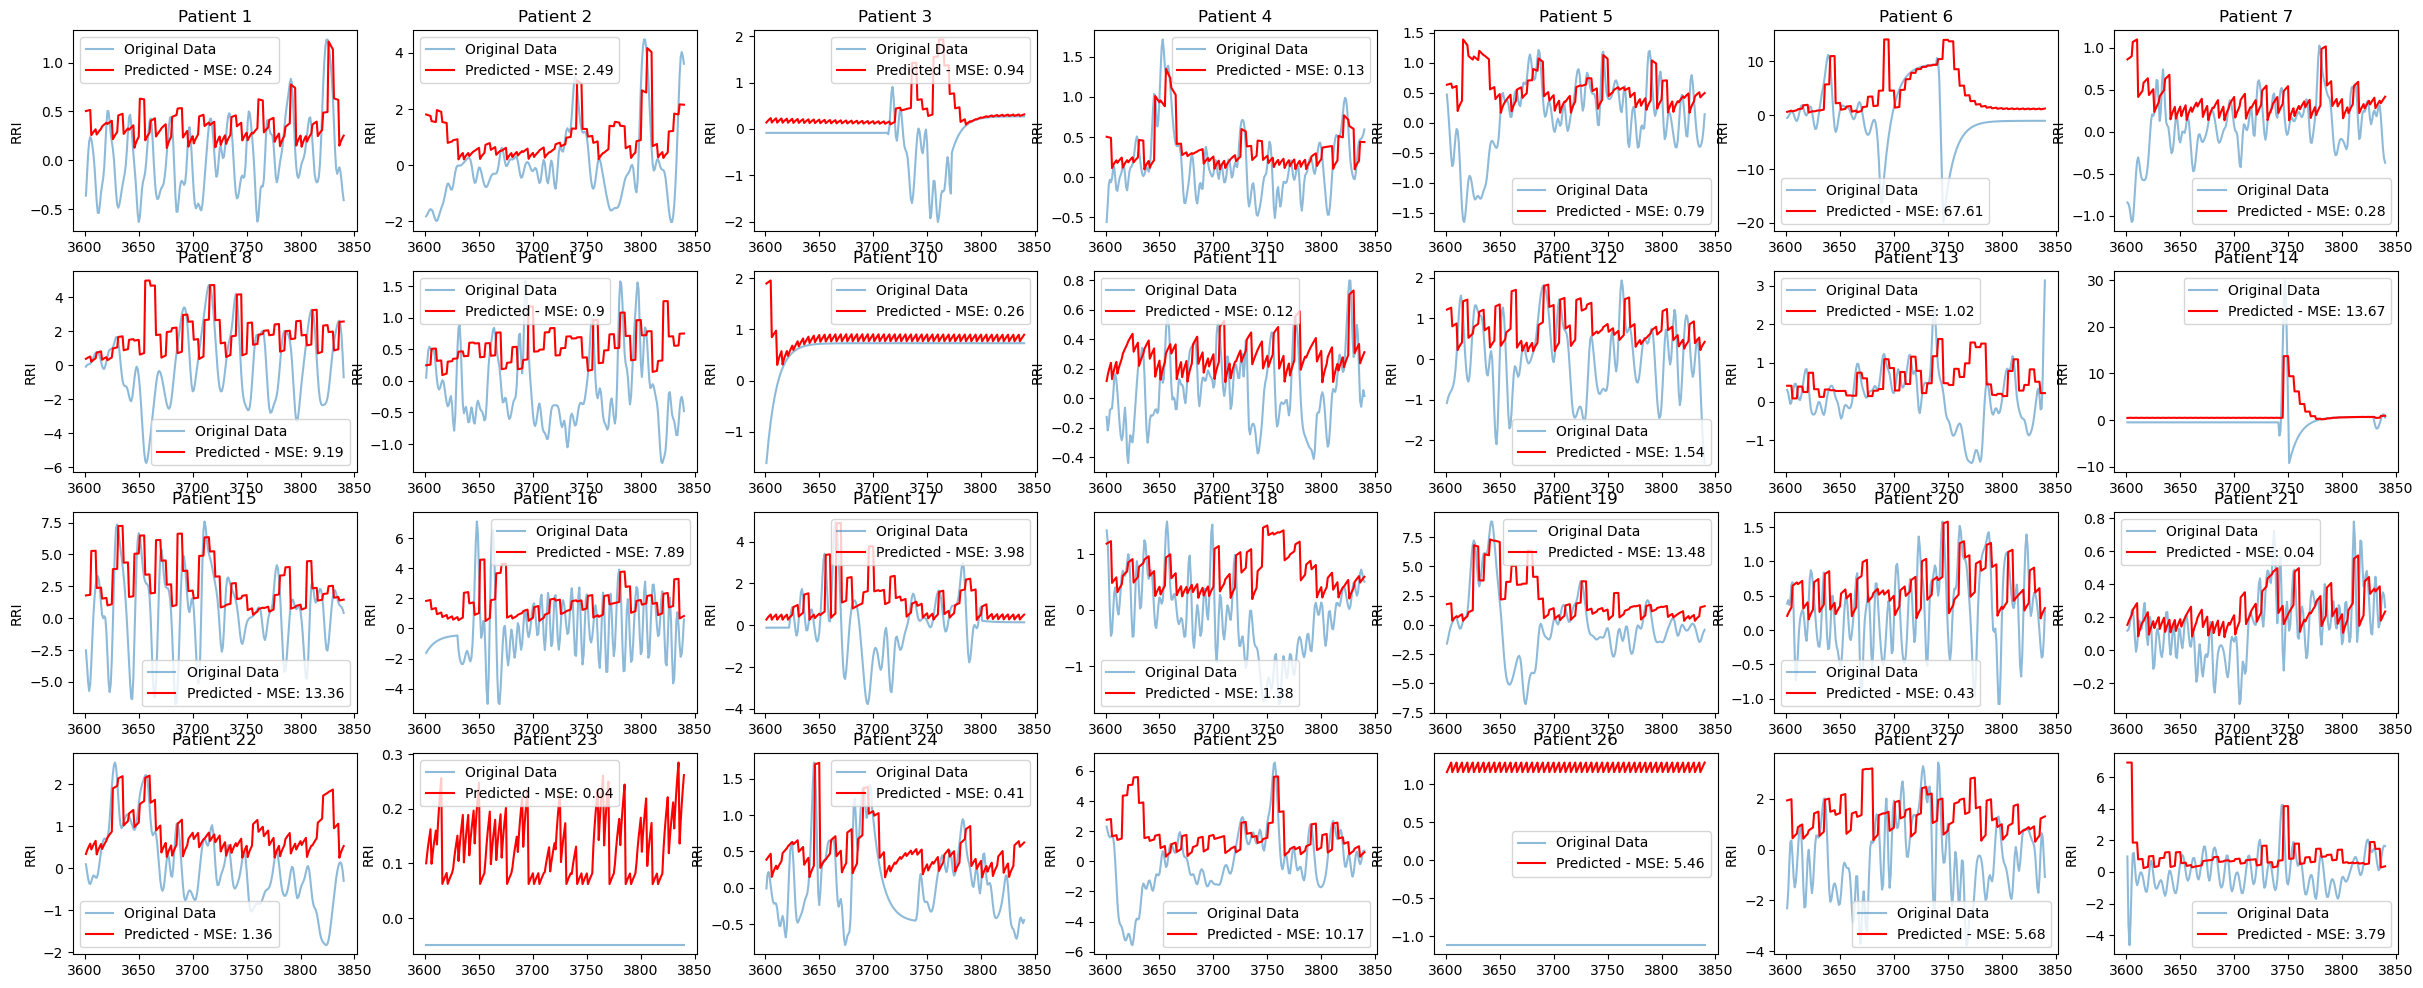

In [607]:
# plots for smoothed data
fig, axs = plt.subplots(4, 7, figsize=(30, 12))
warnings.filterwarnings("ignore")
model_params = {}
mses = []

for i in range(4):
    for j in range(7):
        patient = rris["rri_" + str(i*7+j+1)]
        bis = bis_all["bis_" + str(i*7+j+1)]
        train, test = create_datasets(patient, test_size = 240, differencing = True, periods = 1, smoothing = True, smoothing_level = 0.1)
        model, mse, predictions = fit_data(train, test, exog = bis,  p = 1, q = 1, make_rolling_predictions = True, window = 5)
        model_params["rri_" + str(i*7+j+1)] = model.params
        mses.append(mse)

        # plot prediction data
        axs[i,j].plot(test.index, test, alpha = 0.5, label = 'Original Data')
        axs[i,j].plot(test.index, predictions, color='red', label='Predicted - MSE: ' + str(round(mse, 2)))
        axs[i,j].set_title('Patient ' + str(i*7+j+1))
        axs[i,j].set_ylabel('RRI')
        #axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')
        axs[i,j].legend()

In [608]:
global_results = pd.DataFrame(model_params)
global_results['global_means'] = global_results.mean(axis = 1)
global_results

,rri_1,rri_2,rri_3,rri_4,rri_5,rri_6,rri_7,rri_8,rri_9,rri_10,...,rri_20,rri_21,rri_22,rri_23,rri_24,rri_25,rri_26,rri_27,rri_28,global_means
omega,0.011985,0.036073,0.004584,0.009263,0.027939,0.085864,0.014702,0.031777,0.001375,0.059357,...,0.018275,0.005720,0.054133,0.012509,0.017253,0.067292,0.076507,0.052515,0.011571,0.033708
alpha[1],0.956797,0.948360,0.703418,0.920606,0.944491,0.814780,0.842836,0.879913,0.643991,0.953563,...,0.853110,0.867368,0.894718,0.772561,0.900394,0.924852,0.905431,0.830872,0.731950,0.845727
beta[1],0.000000,0.040922,0.296582,0.026993,0.000000,0.185220,0.157164,0.120087,0.356010,0.037612,...,0.146890,0.132632,0.105282,0.226494,0.099606,0.075148,0.094569,0.169128,0.268050,0.147584


In [609]:
print("Average mse: " + str(np.mean(mses)))

Average mse: 5.9517316575834


### Creating a global model by concatenating

1) plot acf and pacf curves --> should give you an indication of which ps and qs to try. 
2) Then did hyperparameter tuning. 

--> for any test patient or data.
fit all the previous stuff + pre-surgery data. predict the next few seconds.

In [655]:
# concatenating all data
concatenated_data_21 = pd.DataFrame()
for i in range(1, 22):
    patient = rris["rri_" + str(i)]
    train, test = create_datasets(patient, test_size = 0, differencing = True, periods = 1, smoothing = True, smoothing_level = 0.1)
    concatenated_data_21 = pd.concat([concatenated_data_21, train], axis = 0)

/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
Se

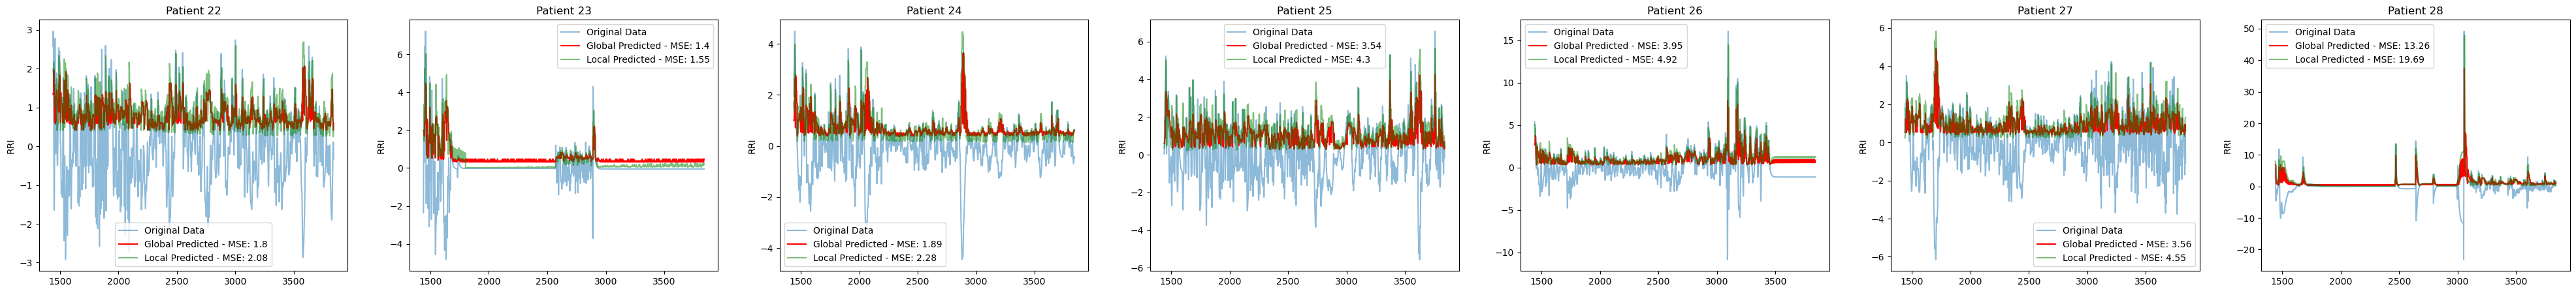

In [683]:
fig, axs = plt.subplots(1, 7, figsize=(50, 5))
warnings.filterwarnings("ignore")

# testing on last 7 patients
for i in range(22, 29):
    patient = rris["rri_" + str(i)]
    bbis = bis_all["bis_" + str(i)]

    train_global, test_global = create_datasets(patient, test_size = 2400, global_df = concatenated_data_21, differencing = True, periods = 1, smoothing = True, smoothing_level = 0.1)
    model, mse_global, predictions_global = fit_data(train_global, test_global, exog = None, p = 1, q = 1, make_rolling_predictions = True, window = 5)

    train_local, test_local = create_datasets(patient, test_size = 2400, differencing = True, periods = 1, smoothing = True, smoothing_level = 0.1)
    model, mse_local, predictions_local = fit_data(train_local, test_local, exog = bbis, p = 1, q = 1, make_rolling_predictions = True, window = 5)

    # plot prediction data
    axs[i-22].plot(test_global.index, test_global, alpha = 0.5, label = 'Original Data')
    axs[i-22].plot(test_global.index, predictions_global, color='red', label='Global Predicted - MSE: ' + str(round(mse_global, 2)))
    axs[i-22].plot(test_local.index, predictions_local, color='green', label='Local Predicted - MSE: ' + str(round(mse_local, 2)), alpha = 0.5)
    axs[i-22].set_title('Patient ' + str(i))
    axs[i-22].set_ylabel('RRI')
    #axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')
    axs[i-22].legend()

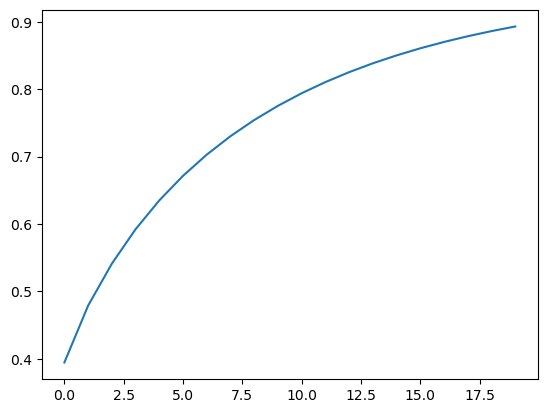

In [636]:
model_concat = arch_model(y = concatenated_data_21, vol="GARCH", p = 2, q = 2, rescale = True).fit(disp="off")
predictions = model_concat.forecast(horizon = 20, reindex = False)
predictions = np.sqrt(predictions.variance.values[-1,:])
plt.plot(predictions)

In [634]:
model_concat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -76776.7
Distribution:                  Normal   AIC:                           153565.
Method:            Maximum Likelihood   BIC:                           153621.
                                        No. Observations:                80640
Date:                Sat, Apr 15 2023   Df Residuals:                    80639
Time:                        23:42:21   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0140  3.373e-03      4.158  3.209e-05 [7.415e-03,2.064e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0932  1.053e-03     88.538      0.000  [9.113e-02,9.526e-02]
alpha[1]       0.8032  8.883e-03     90.419      0.000      [  0.786,  0.821]
alpha[2]       0.0511  1.212e-02      4.217  2.473e-05  [2.735e-02,7.485e-02]
beta[1]    8.5572e-03  1.526e-02      0.561      0.575 [-2.136e-02,3.847e-02]
beta[2]        0.0355  6.809e-03      5.211  1.883e-07  [2.213e-02,4.882e-02]
=============================================================================

Covariance estimator: robust
"""

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 rri_22   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -12098.7
Distribution:                  Normal   AIC:                           24203.4
Method:            Maximum Likelihood   BIC:                           24219.3
                                        No. Observations:                 1440
Date:                Sat, Apr 15 2023   Df Residuals:                     1440
Time:                        21:26:45   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.3264e+04   5485.341      4.241  2.225e-05 

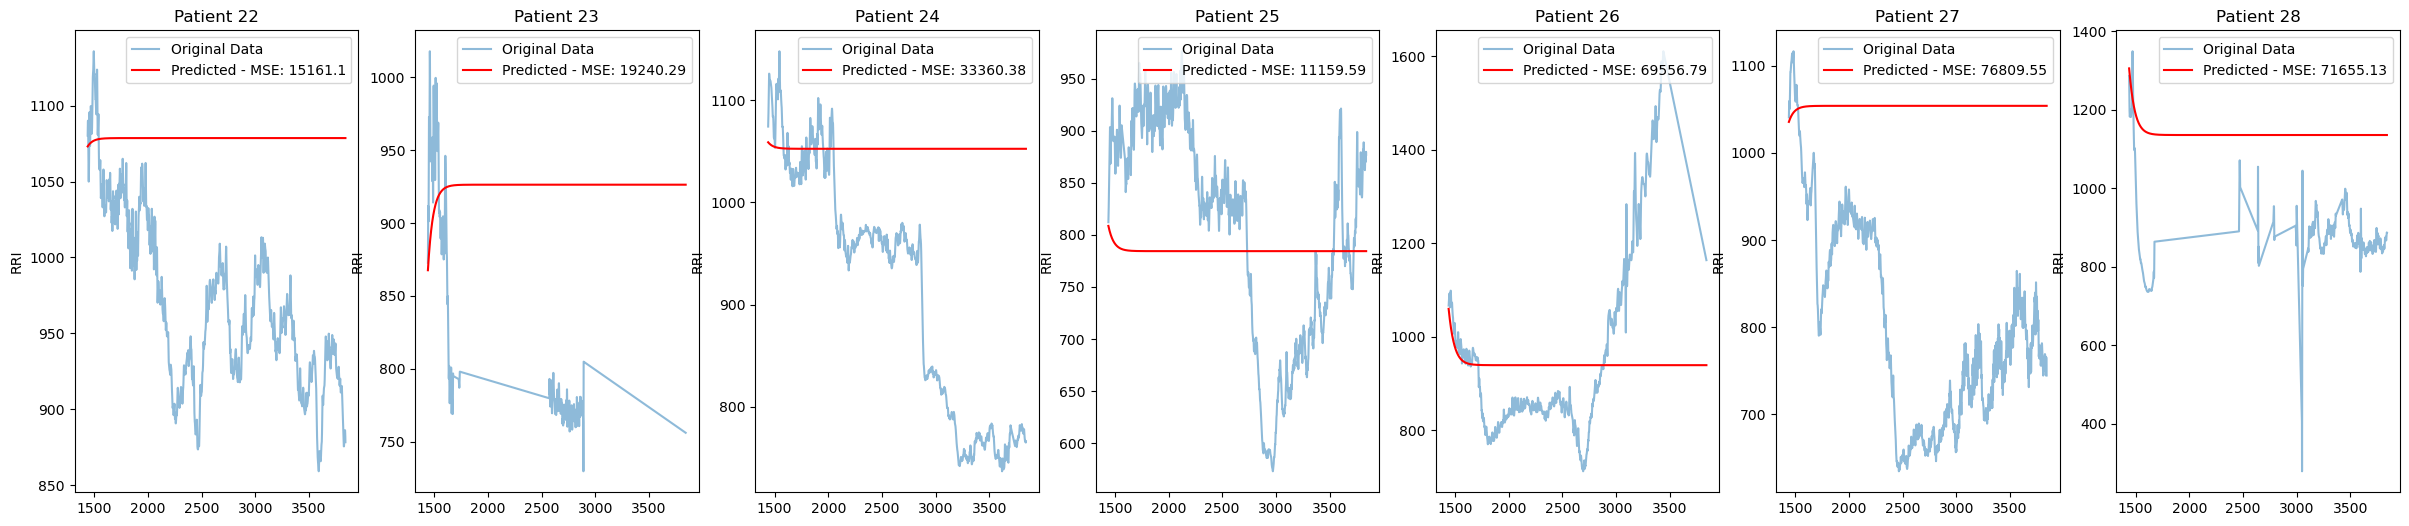

In [606]:
# plots for smoothed data
fig, axs = plt.subplots(1, 7, figsize=(30, 6))
warnings.filterwarnings("ignore")
model_params = {}
mses = []

for i in range(22, 29):
    patient = rris["rri_" + str(i)]
    train = patient[:1440]
    test = patient[1440:]

    # fit model
    exog = bis_all["bis_" + str(i)]
    model, mse, predictions = fit_data(train, test, exog = exog,  p = 1, q = 1, make_rolling_predictions = False, window = 5, starting_values = global_results['global_means'])
    print(model.summary())

    # plot prediction data
    axs[i-22].plot(test.index, test, alpha = 0.5, label = 'Original Data')
    axs[i-22].plot(test.index, predictions, color='red', label='Predicted - MSE: ' + str(round(mse, 2)))
    axs[i-22].set_title('Patient ' + str(i))
    axs[i-22].set_ylabel('RRI')
    #axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')
    axs[i-22].legend()

In [574]:
model.forecast(horizon = 2, reindex = False).variance.values[-1,:]

array([0.07807249, 0.08964303])

In [581]:
test

3601    0.973596
3602   -3.356271
3603   -4.633268
3604   -3.051068
3605   -0.535854
          ...   
3836    0.630990
3837    1.128192
3838    1.508579
3839    1.665589
3840    1.628639
Length: 240, dtype: float64

In [583]:
np.sqrt(model.params['omega'] + model.params['alpha[1]'] * model.resid**2 + model.params['beta[1]'] * model.conditional_volatility**2)

1       1.928848
2       2.569707
3       3.183003
4       3.412572
5       3.159381
          ...   
3831    1.346319
3832    1.015512
3833    0.624092
3834    0.350444
3835    0.279415
Length: 3835, dtype: float64

In [ ]:
global_results['forecast_vol'] = 0.1 * np.sqrt(global_results['global_means']['omega'] + global_results['global_means']['alpha[1]'] * res.resid**2 + res.conditional_volatility**2 * res.params['beta[1]'])

In [507]:
model.params

omega       0.017451
alpha[1]    0.899365
beta[1]     0.100635
Name: params, dtype: float64

In [447]:
model.params[0] + model.params[1] * test[3741] ** 2 + model.params[2] * 0.22424529 ** 2

0.11603251086109778

In [454]:
model = arch_model(train, mean="Zero", vol="GARCH", p = 1, q = 1).fit(disp="off")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2280.03
Distribution:                  Normal   AIC:                           4566.06
Method:            Maximum Likelihood   BIC:                           4584.74
                                        No. Observations:                 3740
Date:                Thu, Apr 13 2023   Df Residuals:                     3740
Time:                        00:59:35   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0175  2.380e-03      7.333  2.242e-13 [1.279e-02,2.211e-02]
alpha[1]       0.8994  1.669e-02     53.885      0.000     [  0.867,  0.932]
beta[1]        0.1006  2.240e-02      4.492  7.060e-06   [5.672e-02,  0.145]
============================================================================

Covariance estimator: robust
"""

In [498]:
test_mod = arch_model(test, mean="Zero", vol="GARCH", p = 1, q = 1)
res = test_mod.fit(update_freq=5, disp="off", starting_values = model.params)
res.forecast(horizon=10).variance.iloc[-1, :]


h.01    0.188163
h.02    0.180305
h.03    0.173365
h.04    0.167234
h.05    0.161819
h.06    0.157036
h.07    0.152811
h.08    0.149080
h.09    0.145784
h.10    0.142872
Name: 3840, dtype: float64

In [497]:
test_mod = arch_model(test, mean="Zero", vol="GARCH", p = 1, q = 1)
res = test_mod.fit(update_freq=5, disp="off")
res.forecast(horizon=10).variance.iloc[-1, :]

h.01    0.188137
h.02    0.180259
h.03    0.173300
h.04    0.167155
h.05    0.161728
h.06    0.156935
h.07    0.152701
h.08    0.148963
h.09    0.145661
h.10    0.142745
Name: 3840, dtype: float64

In [437]:
predictions.variance.values[-1, :]

array([0.20679454, 0.22424529, 0.24169604, 0.25914679, 0.27659754,
       0.29404829, 0.31149904, 0.32894979, 0.34640054, 0.36385129,
       0.38130204, 0.39875279, 0.41620354, 0.43365429, 0.45110504,
       0.46855579, 0.48600654, 0.5034573 , 0.52090805, 0.5383588 ,
       0.55580955, 0.5732603 , 0.59071105, 0.6081618 , 0.62561255,
       0.6430633 , 0.66051405, 0.6779648 , 0.69541555, 0.7128663 ,
       0.73031705, 0.7477678 , 0.76521855, 0.7826693 , 0.80012005,
       0.8175708 , 0.83502155, 0.8524723 , 0.86992305, 0.8873738 ,
       0.90482455, 0.9222753 , 0.93972605, 0.9571768 , 0.97462755,
       0.9920783 , 1.00952905, 1.0269798 , 1.04443055, 1.0618813 ,
       1.07933205, 1.0967828 , 1.11423355, 1.1316843 , 1.14913505,
       1.1665858 , 1.18403655, 1.2014873 , 1.21893805, 1.2363888 ,
       1.25383955, 1.2712903 , 1.28874105, 1.3061918 , 1.32364255,
       1.3410933 , 1.35854405, 1.3759948 , 1.39344555, 1.4108963 ,
       1.42834705, 1.4457978 , 1.46324855, 1.4806993 , 1.49815

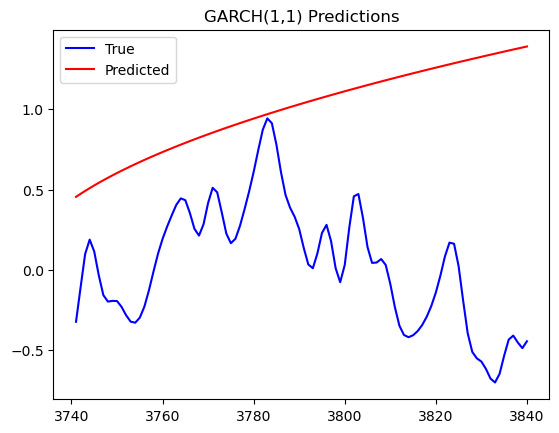

In [407]:
predictions = model.forecast(horizon = test_size, reindex = False)
true = plt.plot(test, color='blue', label='True')
pred = plt.plot(test.index, np.sqrt(predictions.variance.values[-1,:]), color='red', label='Predicted')
plt.title('GARCH(1,1) Predictions')
plt.legend()
plt.show()

In [395]:
#calculating the mean squared error
mse = mean_squared_error(test, np.sqrt(predictions.variance.values[-1,:]))
print('Test MSE: %.3f' % mse)

Test MSE: 1.211


As @Cagdas Ozgenc writes, the problem is that GARCH does not forecast future realizations (which you can observe), but future volatility (which you cannot observe). Thus, classical point forecast error (or accuracy) measures don't make sense.

So, how do we evaluate a GARCH volatility forecast? In fact, one usually not only forecasts volatility using GARCH, but adds distributional assumptions (typically a normal or a t distribution) and outputs a density forecast. The question now becomes how to evaluate a density forecast.

A GARCH model assumes a perfect fit for the conditional variance equation. This feature is due the definition/construction of the GARCH model (note that there is no error term in the conditional variance equation in a GARCH model).

A class of conditional variance models that allows for imperfect fit are stochastic volatility models.

In any case, measuring the goodness of fit of conditional variance models is problematic -- because the conditional variance is unobserved. Thus conventional techniques such as running a regression of the dependent variable (the conditional variance) on the regressors (e.g. lagged conditional variances and lagged squared error terms) and taking the 𝑅2 as a measure of fit do not work.

You can assess how "good" a GARCH model is by looking at model residuals and checking how well they match the model assumptions. Normally you assume the residuals to be i.i.d. You also assume they follow a certain distribution, e.g. a normal distribution. You use this assumption in constructing the likelihood function which is then used for fitting the model via the maximum likelihood estimation (MLE). Thus you could look at the residuals and see how close they are to being i.i.d. and following the assumed distribution.

Aksakal suggested looking at AIC or BIC which gives you model likelihood adjusted for the number of parameters (so as to penalize for overfitting). Looking at model likelihood itself can also be meaningful, but then you have to keep in mind that richer models normally yield higher likelihoods.

In [247]:
test_size = 1000
diff = False
patient_num = 7
if diff:
    train, test = rris_diff['rri_' + str(patient_num)][:len(rris_diff['rri_' + str(patient_num)]) - test_size], rris_diff['rri_' + str(patient_num)][len(rris_diff['rri_' + str(patient_num)]) - test_size:]
else:
    train, test = rris['rri_' + str(patient_num)][:len(rris['rri_' + str(patient_num)]) - test_size], rris['rri_' + str(patient_num)][len(rris['rri_' + str(patient_num)]) - test_size:]
model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1).fit()
model.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 87432.56224357424
Iteration:      2,   Func. Count:     11,   Neg. LLF: 23114.6952008331
Iteration:      3,   Func. Count:     15,   Neg. LLF: 23114.65949776411
Iteration:      4,   Func. Count:     19,   Neg. LLF: 23114.52116872624
Iteration:      5,   Func. Count:     23,   Neg. LLF: 23114.393567539606
Iteration:      6,   Func. Count:     27,   Neg. LLF: 23114.393359956684
Iteration:      7,   Func. Count:     30,   Neg. LLF: 23114.393359968577
Optimization terminated successfully    (Exit mode 0)
            Current function value: 23114.393359956684
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 7


/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.883e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  rri_7   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -23114.4
Distribution:                  Normal   AIC:                           46234.8
Method:            Maximum Likelihood   BIC:                           46252.6
                                        No. Observations:                 2841
Date:                Sat, Apr 08 2023   Df Residuals:                     2841
Time:                        16:24:39   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.6526e+04   1913.989      8.634  5.914e-18 [1.277e+04,2.028e+04]
alpha[1]       0.9703  6.136e-02     15.813  2.514e-56     [  0.850,  1.091]
beta[1]        0.0000  6.498e-02      0.000      1.000     [ -0.127,  0.127]
============================================================================

Covariance estimator: robust
"""

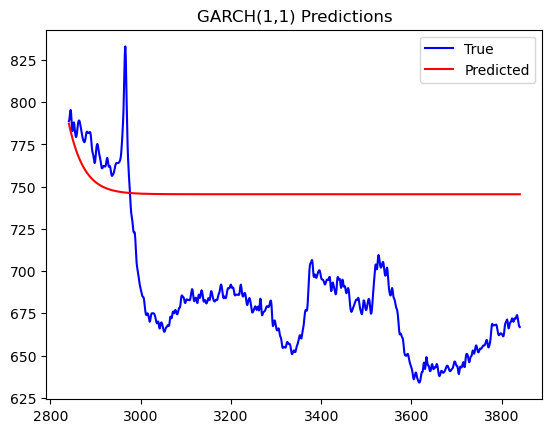

In [248]:
predictions = model.forecast(horizon = test_size, reindex = False)
true = plt.plot(test, color='blue', label='True')
pred = plt.plot(test.index, np.sqrt(predictions.variance.values[-1,:]), color='red', label='Predicted')
plt.title('GARCH(1,1) Predictions')
plt.legend()
plt.show()

### GARCH Rolling Forecasts

Method for creating rolling density forecast from ARMA-GARCH models with option for refitting every n periods with parallel functionality.

In [275]:
# Rolling Forecast
rolling_predictions = []
window = 5
for i in range(0, test_size, window):
    if diff:
        train = rris_diff['rri_' + str(patient_num)][:len(rris_diff['rri_' + str(patient_num)]) - test_size + i]
    else:
        train = rris['rri_' + str(patient_num)][:-(test_size - i)]
    model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1).fit(disp='off')
    pred = model.forecast(horizon = window, reindex = False)
    rolling_predictions.append((np.sqrt(pred.variance.values[-1,:])))

/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.883e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.872e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/edawg/opt/miniconda3/lib/python3.10/site-

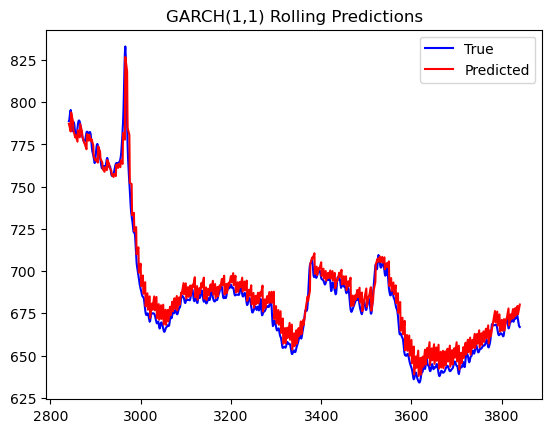

In [276]:
true, = plt.plot(test, color='blue', label='True')
rolling_predictions = np.reshape(rolling_predictions, (1, -1))[0]
pred, = plt.plot(test.index, rolling_predictions, color='red', label='Predicted')
plt.title('GARCH(1,1) Rolling Predictions')
plt.legend()
plt.show()

### Hyperparameter Tuning

Questions

1) Confirm VAR models. Do we fit multiple observations of the same variable or different variables for the same observation?
2) We're seeing a flat line for our predictions for both VARMA and GARCH model. Any tips on how to better our models?
3) Would rolling predictions be helpful in our situation?